### <center> In this notebook i will load the ASCAT and QuikSCAT dataset and merge them in a single scatterometer wind dataset. 

The approach is quite simple: first the QuikSCAT and ASCAT will be loaded in the overlapping period, then a simple linear regression will be built based on this data. Finally the linear regression will be used to correct ascat data towards quikscat-kind values. When coefficients are done, they will be stored on disk for future use. Then with the create_hovmoller_scatterometers.ipynb notebook the ascat hovmoller will be computed based on the correction with this coefficients ($QuikSCAT = A(lat,lon) \cdot ASCAT + B(lat,lon)$). Then with this notebook both hovmollers will be loaded, the alongshore wind stress will be computed and the final dataset is ready to go.

In [1]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import scipy.stats as st
# Just for supressing an annoying warning
import dask
dask.config.set({"array.slicing.split_large_chunks": False})

In [2]:
# Define the overlapping period
overlap_period = pd.date_range('2007-03-21 12:00:00','2009-11-17 12:00:00', freq='d')

In [3]:
def preprocess(data):
    """
    Simple preprocessing function to apply to every ascat/quikscat file
    This just changes some names and modify the lon coordinate
    from -180-180 to 0-360
    """
    print(data.time.dt.strftime('%F').data)
    data = data.rename({'latitude':'lat','longitude':'lon'}).squeeze().drop('depth')
    data = data[['wind_stress',
                 'surface_downward_eastward_stress',
                 'surface_downward_northward_stress',
                 'eastward_wind',
                 'northward_wind',
                 'wind_speed']]
    data = data.rename({'wind_stress':'tau',
                 'surface_downward_eastward_stress':'taux',
                 'surface_downward_northward_stress':'tauy',
                 'eastward_wind':'u',
                 'northward_wind':'v',
                 'wind_speed':'ws'})
    data = data.sel(lat=slice(-60,60))
    data.coords['lon'] = xr.where(data.lon<0,data.lon+360,data.lon)
    data = data.sortby('lon')#.sel(lon=slice(110,291))
    return data.compute()

# load ascat in the overlapping period
ascat = [glob('data/ASCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in overlap_period]
ascat = sum(ascat,[])
ascat = xr.open_mfdataset(ascat, parallel=True, concat_dim='time', combine='nested', preprocess=preprocess)

# load quikscat in the overlapping period
quikscat = [glob('data/QuikSCAT/{}*'.format(d.strftime('%Y%m%d'))) for d in overlap_period]
quikscat = sum(quikscat,[])
quikscat = xr.open_mfdataset(quikscat, parallel=True, concat_dim='time', combine='nested',preprocess=preprocess)

# set a common time vector
ascat    = ascat.reindex({'time':overlap_period})
quikscat = quikscat.reindex({'time':overlap_period})

ascat['wdir'] = (90-np.rad2deg(np.arctan2(-ascat.u,-ascat.v)))%360
ascat['sdir'] = (90-np.rad2deg(np.arctan2(-ascat.taux,-ascat.tauy)))%360

quikscat['wdir'] = (90-np.rad2deg(np.arctan2(-quikscat.u,-quikscat.v)))%360
quikscat['sdir'] = (90-np.rad2deg(np.arctan2(-quikscat.taux,-quikscat.tauy)))%360

['2007-07-30']
['2007-04-08']
['2008-08-18']
['2007-07-13']
['2007-12-22']
['2008-07-01']
['2008-03-24']
['2007-10-19']
['2007-10-31']
['2008-07-30']
['2007-10-22']
['2008-02-04']
['2007-08-01']
['2007-12-12']
['2007-08-05']
['2007-05-23']
['2008-09-12']
['2007-09-13']
['2008-05-25']
['2007-10-14']
['2009-08-30']
['2007-10-15']
['2009-04-21']
['2008-11-08']
['2009-07-17']
['2007-06-23']
['2009-02-03']
['2007-08-17']
['2008-09-23']
['2007-11-29']
['2009-05-10']
['2007-06-21']
['2009-04-14']
['2009-08-16']
['2007-06-01']
['2007-10-13']
['2009-08-18']
['2007-04-17']
['2008-10-31']
['2008-02-19']
['2009-08-21']
['2008-05-05']
['2008-12-22']
['2008-03-30']
['2009-08-12']
['2008-12-12']
['2009-06-08']
['2007-06-09']
['2009-10-21']
['2009-11-14']
['2009-07-26']
['2007-12-09']
['2007-11-06']
['2007-08-07']
['2009-10-20']
['2009-07-23']
['2007-09-10']
['2009-01-13']
['2007-09-08']
['2009-02-27']['2007-06-10']

['2008-01-31']
['2009-05-06']
['2009-06-07']
['2008-06-11']
['2007-09-29']
['2007-05-

In [25]:
# Compute linear regression parameters for the globe
def apply_linmodel(x,y,out):
    if np.isnan(x).sum() == len(x):
        return np.nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    model = st.linregress(x[mask],y[mask])
    return eval(f'model.{out}')

x,y       = ascat.sel(lat=slice(-50,50)),quikscat.sel(lat=slice(-50,50))
# x,y       = x.chunk({'time':-1, 'lon':-1, 'lat':20}),y.chunk({'time':-1, 'lon':-1, 'lat':20})
linmodels = []
for v in ['u','v','ws','taux','tauy','tau','wdir','sdir']:
    print(v)
    slope     = xr.apply_ufunc(apply_linmodel,x[v],y[v],'slope', input_core_dims=[['time'],['time'],[]], vectorize=True, dask= "forbidden")
    intercept = xr.apply_ufunc(apply_linmodel,x[v],y[v],'intercept', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
    rvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'rvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")**2
    pvalue    = xr.apply_ufunc(apply_linmodel,x[v],y[v],'pvalue', input_core_dims=[['time'],['time'],[]], vectorize=True, dask="forbidden")
    lm = xr.concat([slope,intercept,rvalue,pvalue],'parameter')
    lm.coords['parameter'] = ['slope','intercept','rsquared','pvalue']
    linmodels.append(lm.to_dataset(name=f'lm_{v}'))
linmodels = xr.merge(linmodels)

u
v
ws
taux
tauy
tau
wdir
sdir


In [38]:
linmodels.to_netcdf('~/storage/ASCAT-QuikSCAT_linregression.nc')

Text(0.5, 1.0, '$R^2$ meridional wind stress')

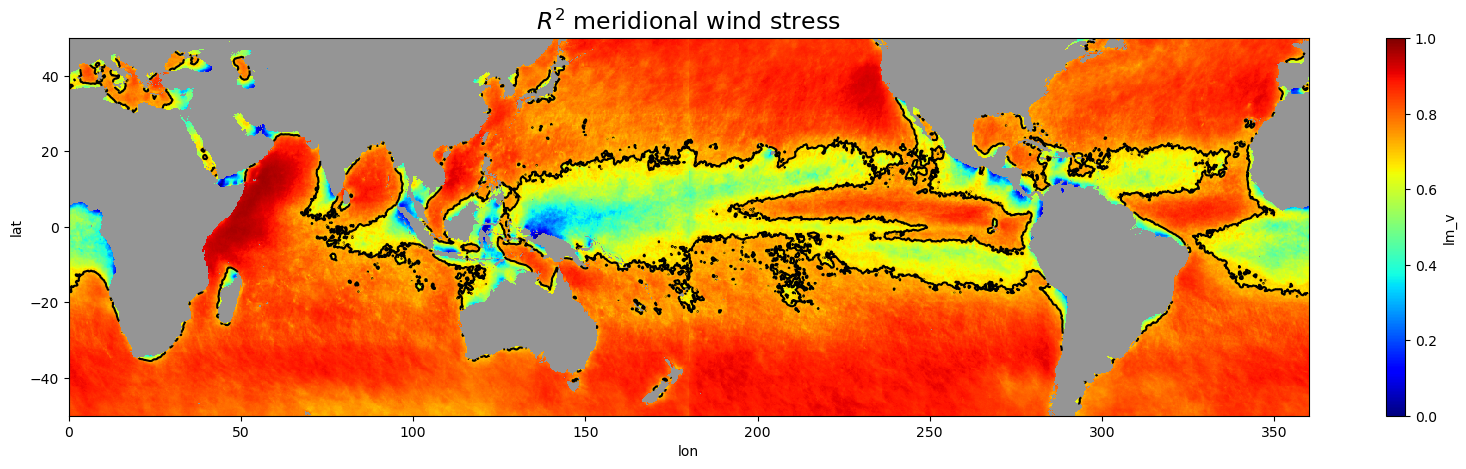

In [40]:
# some plot
fig, ax = plt.subplots(1,1, figsize=(20,5), dpi=100, facecolor='w')
(np.isnan(linmodels.lm_ws[0])).where(np.isnan(linmodels.lm_ws[0])).plot(ax=ax, add_colorbar=False, cmap='Greys')
linmodels.lm_v.sel(parameter='rsquared').plot(cmap='jet', ax=ax, vmin=0, vmax=1)
linmodels.lm_v.sel(parameter='rsquared').plot.contour(levels=[0.7], colors='k', ax=ax)
ax.set_title('$R^2$ meridional wind stress', fontsize=17)

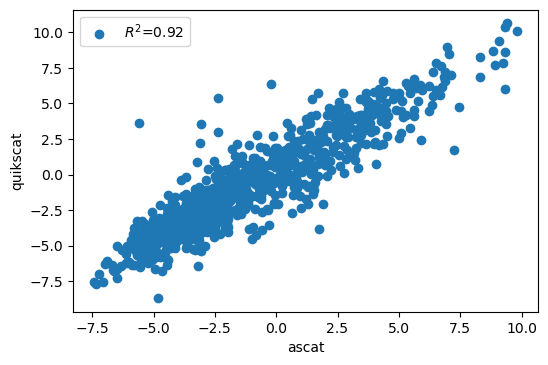

In [ ]:
# check relationship for some points
plt.figure(dpi=100, facecolor='w')
x,y=ascat['u'].sel(lon=280, lat=-30, method='nearest'),quikscat['u'].sel(lon=280, lat=-30, method='nearest')
r = apply_linmodel(x,y,'rvalue')
plt.scatter(x,y,
            label='$R^2$={:.2f}'.format(r))
plt.xlabel('ascat')
plt.ylabel('quikscat')
plt.legend()